In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from geofunctions import utils
import os

In [69]:
full_df = gpd.read_file("../data/to_map/geohash_work_home_stat_monthly.geojson")

In [70]:
full_df.head()

,geohash,num_homes,num_works,type,month,flag_good_month,geometry
0,swnt70p,0,1,Work,201901,False,"POLYGON ((34.67285 31.78207, 34.67285 31.78345..."
1,swnt72d,0,1,Work,201901,False,"POLYGON ((34.6756 31.78619, 34.6756 31.78757, ..."
2,swnt74z,1,0,Home,201901,False,"POLYGON ((34.68796 31.78207, 34.68796 31.78345..."
3,swnt75n,3,0,Home,201901,False,"POLYGON ((34.68933 31.7807, 34.68933 31.78207,..."
4,swnt75p,1,0,Home,201901,False,"POLYGON ((34.68933 31.78207, 34.68933 31.78345..."


In [71]:
blds_df = gpd.read_file(
    utils.get_path("raw", "buildings", "blds_gushdan/buildings_within_gushdan_new.shp")
)

KeyboardInterrupt: 

In [20]:
blds_df = blds_df.to_crs(4326)

In [28]:
blds_df["FCODE_12"].value_counts(normalize=True)

FCODE_12
0      0.928795
225    0.030746
222    0.019987
223    0.009777
221    0.007206
224    0.003071
226    0.000419
Name: proportion, dtype: float64

In [21]:
import pygeohash as gh

blds_df["geohash"] = blds_df.geometry.apply(
    lambda x: gh.encode(x.centroid.x, x.centroid.y, precision=7)
)

In [52]:
blds_df["flag_residential"] = blds_df["FCODE_12"] == 0
blds_df_pivot = pd.pivot_table(
    blds_df[["geohash", "flag_residential", "ADDR_ID"]],
    index="geohash",
    columns="flag_residential",
    values="ADDR_ID",
    aggfunc="count",
)
blds_df_pivot.fillna(0, inplace=True)
blds_df_pivot.columns = ["num_non_residential", "num_residential"]

In [53]:
blds_df_pivot.reset_index(inplace=True)

In [76]:
blds_df_pivot.shape

(37555, 3)

In [79]:
df_blds = full_df.merge(blds_df_pivot, on="geohash", how="outer")

In [80]:
df_blds["num_homes"].fillna(0, inplace=True)
df_blds["num_residential"].fillna(0, inplace=True)
df_blds["num_non_residential"].fillna(0, inplace=True)

In [81]:
df_blds.groupby("month").size()

month
201901     5718
201904     5206
201907     5990
201908     5420
201909     5654
201911     5176
201912     3696
202001    15838
202002     7663
202003    10899
202004     4190
202005    14343
202006    16357
202007    18641
202008    18098
202009    20215
202010    16889
202011    19059
202101    17893
202102    14042
202103    15243
202104    14913
202105    13207
202106    12306
202107    12558
202108     8894
202109     9861
202110     8144
202111     7366
202112    16755
202201    13218
202202    17035
202203    15510
202204    14259
202205    18508
202206    18027
202207    16775
202208    17725
202209    16838
202210    15621
202211    16009
202301    16503
202302    16470
202303    17005
202304    14790
202305    16850
202306    16217
202309    14701
dtype: int64

In [74]:
# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN) grouped by month
error_summary = (
    df_blds.groupby("month")
    .apply(
        lambda x: pd.Series(
            {
                "True Positives": len(
                    x[(x["num_homes"] > 0) & (x["num_residential"] > 0)]
                ),
                "False Positives": len(
                    x[(x["num_homes"] > 0) & (x["num_residential"] == 0)]
                ),
                "True Negatives": len(
                    x[(x["num_homes"] == 0) & (x["num_residential"] == 0)]
                ),
                "False Negatives": len(
                    x[(x["num_homes"] == 0) & (x["num_residential"] > 0)]
                ),
            }
        )
    )
    .reset_index()
)

error_summary.columns = [
    "month",
    "True Positives",
    "False Positives",
    "True Negatives",
    "False Negatives",
]

# Calculate Precision and Recall
error_summary["Precision"] = error_summary["True Negatives"] / (
    error_summary["True Negatives"] + error_summary["False Negatives"]
).replace(0, np.nan)
error_summary["Recall"] = error_summary["True Negatives"] / (
    error_summary["True Negatives"] + error_summary["False Positives"]
).replace(0, np.nan)

error_summary

,month,True Positives,False Positives,True Negatives,False Negatives,Precision,Recall
0,201901,4002,45,212,1459,0.126870,0.824903
1,201904,3867,50,148,1141,0.114818,0.747475
2,201907,4551,74,164,1201,0.120147,0.689076
3,201908,4305,76,133,906,0.128008,0.636364
4,201909,4494,75,150,935,0.138249,0.666667
5,201911,4045,80,133,918,0.126546,0.624413
6,201912,2805,63,85,743,0.102657,0.574324
7,202001,11960,258,539,3081,0.148895,0.676286
8,202002,5659,69,192,1743,0.099225,0.735632
9,202003,8397,125,298,2079,0.125368,0.704492


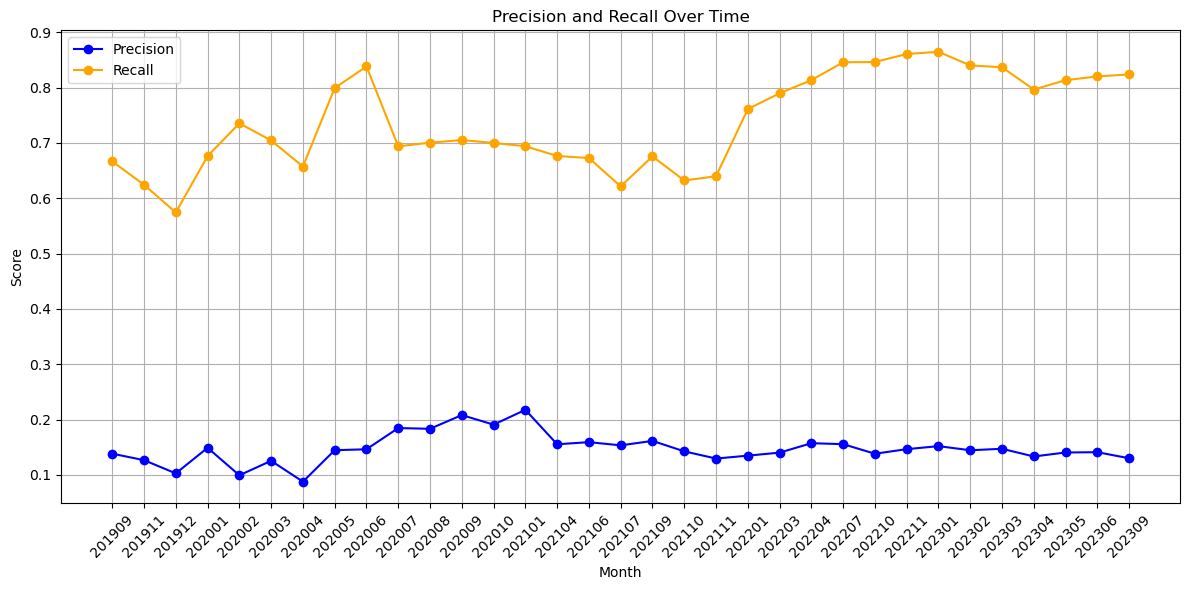

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(
    error_summary["month"],
    error_summary["Precision"],
    marker="o",
    label="Precision",
    color="blue",
)
plt.plot(
    error_summary["month"],
    error_summary["Recall"],
    marker="o",
    label="Recall",
    color="orange",
)
plt.title("Precision and Recall Over Time")
plt.xlabel("Month")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Look at examples of false positives: people live in non-residential buildings

In [61]:
geohash_wrong = df_blds[
    (df_blds.month == "202001")
    & (df_blds["num_homes"] > 0)
    & (df_blds["num_residential"] == 0)
]["geohash"].unique()

In [ ]:
df_blds

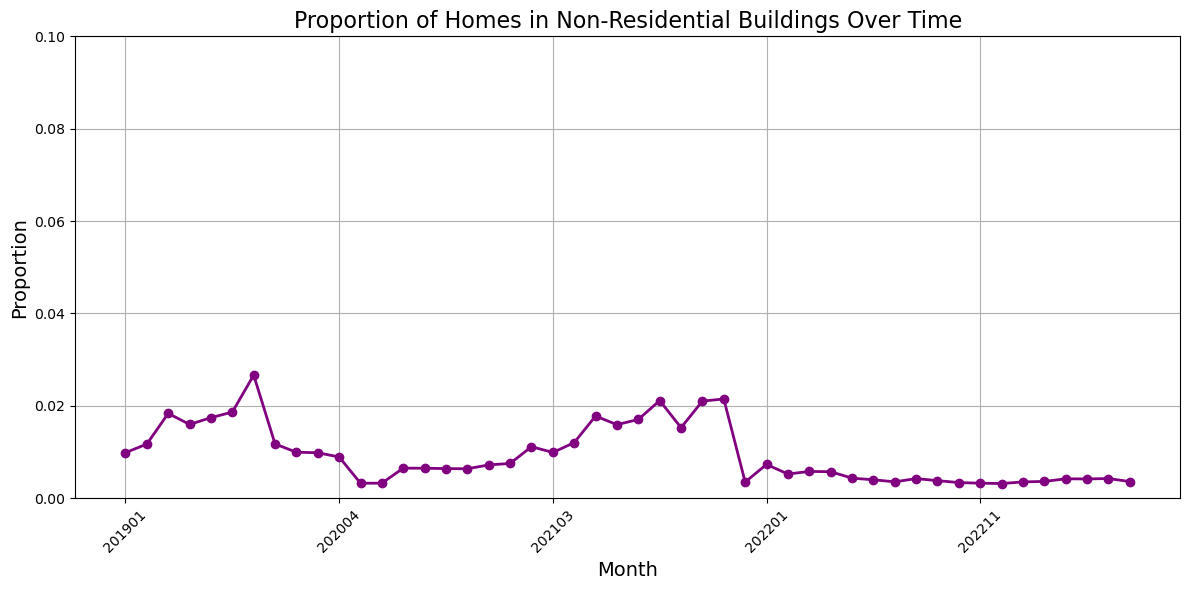

In [83]:
import matplotlib.pyplot as plt

# Calculate the proportion of homes in non-residential buildings by month
proportion_non_residential = (
    df_blds[(df_blds["num_homes"] > 0) & (df_blds["num_residential"] == 0)]
    .groupby("month")["num_homes"]
    .sum() / df_blds.groupby("month")["num_homes"].sum()
)

# Plotting the results
plt.figure(figsize=(12, 6))
proportion_non_residential.plot(marker='o', color='purple', linestyle='-', linewidth=2)
plt.title("Proportion of Homes in Non-Residential Buildings Over Time", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 0.1)
plt.grid()
plt.tight_layout()
plt.show()

In [64]:
df_blds[
    (df_blds.month == "202001")
    & (df_blds["num_homes"] > 0)
    & (df_blds["num_residential"] == 0)
].explore()

## Save dataset of wrong geohashes

In [85]:
df_blds[(df_blds["num_homes"] > 0) & (df_blds["num_residential"] == 0)][["geohash","month"]].drop_duplicates().to_csv(utils.get_path("processed","buildings","geohash_month_non_residential.csv"))